##

# Predictive Analysis of Diabetes Risk

## 0. Imports

In [111]:

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from abc import ABC, abstractmethod
from typing import List
from copy import copy, deepcopy

np.random.seed(42)


## 1. Data Preparation

### 1.1. Fetch the Data

In [112]:
from Scripts.DataDownloadScripts.DataFetch import download_dataset
folder_path = "/Data/InputData/"
if not os.path.exists(folder_path + 'diabetes.csv'):
  download_dataset(folder_path)


### 1.2. Load the data

In [113]:
data = pd.read_csv('./Data/InputData/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 1.3. Split the data

In [114]:
def split_data_to_train_dev_test(wholeData, train_frac=0.7):
  shuffled_data = wholeData.sample(frac=1, random_state=42).reset_index(drop=True)
  m = len(shuffled_data)
  dev_frac = (1 - train_frac) / 2
  
  train_end = int(train_frac * m)
  dev_end = train_end + int(dev_frac * m)

  train_set = shuffled_data[:train_end]
  dev_set = shuffled_data[train_end:dev_end]
  test_set = shuffled_data[dev_end:]

  print(f'Train set size: {train_end}')
  print(f'Dev set size: {dev_end - train_end}')
  print(f'Test set size: {m - dev_end}')
  return train_set, dev_set, test_set

In [115]:
train_set, dev_set, test_set = split_data_to_train_dev_test(data)

Train set size: 537
Dev set size: 115
Test set size: 116


In [116]:
train_set.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98,58,33,190,34.0,0.430,43,0
1,2,112,75,32,0,35.7,0.148,21,0
2,2,108,64,0,0,30.8,0.158,21,0
3,8,107,80,0,0,24.6,0.856,34,0
4,7,136,90,0,0,29.9,0.210,50,0


In [117]:
dev_set.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
537,1,89,24,19,25,27.8,0.559,21,0
538,2,197,70,45,543,30.5,0.158,53,1
539,4,90,88,47,54,37.7,0.362,29,0
540,11,138,76,0,0,33.2,0.420,35,0
541,0,91,68,32,210,39.9,0.381,25,0


In [118]:
test_set.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
652,4,115,72,0,0,28.9,0.376,46,1
653,6,0,68,41,0,39.0,0.727,41,1
654,2,71,70,27,0,28.0,0.586,22,0
655,3,88,58,11,54,24.8,0.267,22,0
656,0,113,80,16,0,31.0,0.874,21,0


In [119]:
def convert_to_x_y(data):
  X = data.drop('Outcome', axis=1).to_numpy()
  Y = data['Outcome'].to_numpy()[:, np.newaxis]
  return X.T, Y.T

train_X, train_Y = convert_to_x_y(train_set)
dev_X, dev_Y = convert_to_x_y(dev_set)
test_X, test_Y = convert_to_x_y(test_set)

print(train_Y.shape, train_X.shape)

(1, 537) (8, 537)


## 2. Own Implementation Model Blocks

In [120]:
# helper to have the structure of activation functions
class ActivationFunction:
  def __init__(self, name, forward, backward):
    self.name = name
    self.forward = forward
    self.backward = backward

### 2.1. Adam Optimizer

Adam is an optimizer that computes adaptive learning rates for each parameter. 
It takes into account both the first-order momentum and the second-order momentum.

Momentum part
$$v_{dW} := \beta _1 v_{dW} + (1 - \beta_1)dW$$
$$v_{db} := \beta _1 v_{db} + (1 - \beta_1)db$$ 

RMSprop part
$$s_{dW} := \beta _2 s_{dW} + (1 - \beta_2)dW^2$$
$$s_{db} := \beta _2 s_{db} + (1 - \beta_2)db^2$$ 

bias correction
$$v_{dW}' = \frac{v_{dW}}{1 - \beta _1 ^t}$$
$$v_{db}' = \frac{v_{db}}{1 - \beta _1 ^t}$$ 

$$s_{dW}' = \frac{s_{dW}}{1 - \beta _2 ^t}$$
$$s_{db}' = \frac{s_{db}}{1 - \beta _2 ^t}$$ 

Gradient update
$$W := W - \alpha \frac{v_{dW}'}{\sqrt{s_{dW}'} + \varepsilon}$$
$$b := b - \alpha \frac{v_{db}'}{\sqrt{s_{db}'} + \varepsilon}$$

In [121]:
class AdamOptimizer:
  def __init__(self, shape, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.s = np.zeros(shape)
    self.v = np.zeros(shape)
    self.t = 0
  
  def update(self, grad):
    self.t += 1
    # counting momentum and RMSprop terms
    self.v = self.beta1 * self.v + (1 - self.beta1) * grad
    self.s = self.beta2 * self.s + (1 - self.beta2) * grad * grad
    
    # bias correction
    self.v_corrected = self.v / (1 - self.beta1**self.t)
    self.s_corrected = self.s / (1 - self.beta2**self.t)
    
    grad = self.learning_rate * self.v_corrected / (np.sqrt(self.s_corrected) + self.epsilon)
    return grad

### 2.2 Model Layers

### 2.2.0 Helper Abstract Classes

In [122]:
class NeuralNetworkLayer(ABC):
  def __init__(self):
    self.n_x = None
    self.prev_n_x = None
  
  @abstractmethod
  def forward(self, a_prev, is_training=False):
    pass

  @abstractmethod
  def backward(self, da):
    pass

  def update_params(self):
    pass
  
  def __str__(self):
    return f'{self.__class__.__name__}({self.n_x})'

In [123]:
class Classifier(ABC):
  def __init__(self):
    pass
  
  def compute_cost(self, a, y):
    pass
  
  def backward(self):
    pass
  
  def forward(self, a):
    pass

### 2.2.1 Dense Layer

#### Forward Pass
This layer has two parameters, the weights and the bias. The forward pass is given by:
$$z^{[l]} = W^{[l]} a^{[l-1]} + b^{[l]}$$

$$a^{[l]} = g(z^{[l]})$$

Important think to note are the shapes of the variables:
- $W^{[l]}$ has shape $(n^{[l]}, n^{[l-1]})$
- $b^{[l]}$ has shape $(n^{[l]}, 1)$
- $z^{[l]}$ has shape $(n^{[l]}, m)$
- $a^{[l]}$ has shape $(n^{[l]}, m)$

Where $n^{[l]}$ is the number of neurons in the layer $l$ and $m$ is the number of samples.

#### Backward Pass
To count backward pass we will use chain rule of calculus. We only need to calculate the derivatives within this layer. The derivatives are given by:
$$\frac{\partial a}{\partial z} = g'(z)$$
$$\frac{\partial z}{\partial W} = a^{[l-1]}$$
$$\frac{\partial z}{\partial b} = 1$$
$$\frac{\partial z}{\partial a^{[l-1]}} = W^{[l]T}$$

So the derivatives of the loss with respect to the parameters are:
$$\frac{\partial L}{\partial W^{[l]}} = \frac{1}{m} \frac{\partial L}{\partial z^{[l]}} a^{[l-1]T}$$
$$\frac{\partial L}{\partial b^{[l]}} = \frac{1}{m} \sum \frac{\partial L}{\partial z^{[l]}}$$
$$\frac{\partial L}{\partial a^{[l-1]}} = W^{[l]T} \frac{\partial L}{\partial z^{[l]}}$$


In [124]:
class DenseLayer(NeuralNetworkLayer):
  # if you want to disable dropout, set keep_prob to 1
  def __init__(self, prev_n_x, n_x, activation_function : ActivationFunction, learning_rate=0.001, keep_prob = 1, beta1=0.9, beta2=0.999, epsilon=1e-8):
    super().__init__()
    self.prev_n_x = prev_n_x
    self.n_x = n_x
    self.activation_function = activation_function
    self.W = np.random.randn(n_x, prev_n_x) / np.sqrt(prev_n_x) # using xavier initialization
    self.b = np.zeros((n_x, 1))
    self.keep_prob = keep_prob
    self.WOptimizer = AdamOptimizer(self.W.shape, learning_rate, beta1, beta2, epsilon)
    self.bOptimizer = AdamOptimizer(self.b.shape, learning_rate, beta1, beta2, epsilon)
    
  def forward(self, a_prev, is_training=False):
    self.a_prev = a_prev
    self.z = np.dot(self.W, a_prev) + self.b
    self.a = self.activation_function.forward(self.z)
    # dropout part, if keep_prob == 1, then no dropout
    if self.keep_prob != 1 and is_training:
      d = np.random.rand(self.a.shape[0], self.a.shape[1]) < self.keep_prob
      a = self.a * d
      a /= self.keep_prob
      return a
    return self.a
  
  def backward(self, da, l2_lambda=0):
    """if you want to use L2 regularization, set l2_lambda to a value greater than 0"""
    m = self.a_prev.shape[1]
    dz = da * self.activation_function.backward(self.z)
    self.dW = np.dot(dz, self.a_prev.T) / m
    self.db = np.sum(dz, axis=1, keepdims=True) / m
    da_prev = np.dot(self.W.T, dz)
    
    if l2_lambda > 0:
      self.dW += l2_lambda * self.W / m
    
    self.__update_params()
    return da_prev
  
  def __update_params(self):
    self.W -= self.WOptimizer.update(self.dW)
    self.b -= self.bOptimizer.update(self.db)
    

#### 2.2.2 Batch Normalization
##### Forward propagation
In each step we calculate the $z^{[l]}$ as in regular NN Dense Layer, but we don't need to calculate $b^{[l]}$ as we will normalize the input. 
$$ z^{[l]} = W^{[l]}a^{[l-1]}$$

In each step of **training** we calculate the mean and variance of the input and normalize it using the following formula:
$$ \mu = \frac{1}{m} \sum_{i=1}^{m} z^{(i)}$$
$$ \sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (z^{(i)} - \mu)^2$$

We will be using those formulas with parameter ```axis=1```, to calculate deviation and mean of all input data.

In the prediction step, we will use the mean and variance calculated during training.

Our normalized $z$ will be calculated as follows:
$$ z_{norm}^{[l]} = \frac{z^{[l]} - \mu}{\sqrt{\sigma^2 + \varepsilon}}$$
Where $\varepsilon$ is a small number to avoid division by zero.

And our $z$ will be calculated as follows: 
$$\tilde{z}^{[l]} = \gamma^{[l]} z_{\text{norm}} + \beta^{[l]}$$

And layer activation will be:
$$a^{[l]} = g^{[l]}(\tilde{z}^{[l]})$$

##### Backward propagation
Here the goal is to calculate the gradients of the parameters $W^{[l]}$, $\gamma^{[l]}$ and $\beta^{[l]}$.

We will use chain rule to calculate derivatives of the loss function.

The input to the backprop will be the $\frac{\partial L}{\partial a^{[l]}}$, so the ```da``` parameter. Because in the next layer we can calculate how much of the change of $z^{[l+1]}$ will cause change of $a^{[l]}$. 

Having this ```da``` we can calculate the gradients of the parameters as follows (the easiest is to implement like code):
```python
dz_tilde = da * g'(z_tilde)
dz_norm = dz_tilde * gamma
dgamma = dz_tilde * z_norm_mean # z_norm_mean is mean over all m z_norm examples
dbeta = dz_tilde
da_prev = W * dz
```
Calculating derivative of ```z_norm``` over ```z``` is more complicated, because we need to calculate derivative over mean and variance. I have found some formulas for that in the internet.



In [125]:
class BatchNormalizationLayer(NeuralNetworkLayer):
  # if you want to disable dropout, set keep_prob to 1
  def __init__(self, prev_n_x, n_x, activation_function : ActivationFunction, learning_rate=0.001, keep_prob = 1, beta1=0.9, beta2=0.999, epsilon=1e-8):
    super().__init__()
    self.gamma = np.ones((n_x, 1)) 
    self.beta = np.zeros((n_x, 1))
    self.W = np.random.randn(n_x, prev_n_x) / np.sqrt(prev_n_x) # using xavier initialization
    self.eps = epsilon
    self.prev_n_x = prev_n_x
    self.n_x = n_x
    self.mean = None
    self.var = None
    self.keep_prob = keep_prob
    self.g = activation_function
    
    # I will use Adam to speed up the learning
    self.WOptimizer = AdamOptimizer(self.W.shape, learning_rate, beta1, beta2, epsilon)
    self.gammaOptimizer = AdamOptimizer(self.gamma.shape, learning_rate, beta1, beta2, epsilon)
    self.betaOptimizer = AdamOptimizer(self.beta.shape, learning_rate, beta1, beta2, epsilon)
    
  def forward(self, a_prev, is_training = False):
    self.a_prev = a_prev
    self.z = self.W @ a_prev
    if is_training:
      self.mean = np.mean(self.z, axis=1, keepdims=True)
      self.var = np.var(self.z, axis=1, keepdims=True)
    self.z_norm = (self.z - self.mean) / np.sqrt(self.var + self.eps)
    self.z_tilde = self.gamma * self.z_norm + self.beta
    self.a = self.g.forward(self.z_tilde)
    # dropout part, if keep_prob == 1, then no dropout
    if self.keep_prob != 1 and is_training:
      d = np.random.rand(self.a.shape[0], self.a.shape[1]) < self.keep_prob
      a = self.a * d
      a /= self.keep_prob
      return a
    return self.a

  def backward(self, da, l2_lambda=0):
    """if you want to use L2 regularization, set l2_lambda to a value greater than 0"""
    m = da.shape[1]
    
    dz_tilde = da * self.g.backward(self.z_tilde)
    
    self.dgamma = np.sum(dz_tilde * self.z_norm, axis=1, keepdims=True)
    self.dbeta = np.sum(dz_tilde, axis=1, keepdims=True)
    
    dz_norm = dz_tilde * self.gamma
    
    dz_minus_mu = self.z - self.mean
    dvar = np.sum(dz_norm * dz_minus_mu * (-0.5) * (self.var + self.eps) ** (-1.5), axis=1, keepdims=True)
    
    dmu = np.sum(-dz_norm / np.sqrt(self.var + self.eps), axis=1, keepdims=True) + dvar * np.mean(-2 * dz_minus_mu, axis=1, keepdims=True)
    
    dz = dz_norm / np.sqrt(self.var + self.eps) + dvar * 2 * dz_minus_mu / m + dmu / m
    
    self.dW = dz @ self.a_prev.T / m
    # regularization part
    if l2_lambda > 0:
      self.dW += l2_lambda * self.W / m
    
    da_prev = self.W.T @ dz
    
    self.__update_params()
    
    return da_prev

  def __update_params(self):
    self.W -= self.WOptimizer.update(self.dW)
    self.gamma -= self.gammaOptimizer.update(self.dgamma)
    self.beta -= self.betaOptimizer.update(self.dbeta)
    

### 2.2.3 Binary Cross-Entropy Loss Layer

This layer will calculate the binary cross-entropy loss function.

Cost function for one example will be given by the formula:
$$\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \ln(a^{(i)}) - (1-y^{(i)} )  \ln(1-a^{(i)})$$

And the total cost function will be given as mean of all examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

In [126]:
class BinaryCrossEntropy:
  def __init__(self, eps=1e-8):
    self.eps = eps
  
  def compute_cost(self, A, Y):
    m = Y.shape[1]
    # print(A.shape, Y.shape)
    # print(A, Y)
    assert(A.shape == Y.shape)
    assert(Y.shape[0] == 1)
    
    eps = 1e-8
    A = np.clip(A, eps, 1 - eps)
    cost = - (Y @ np.log(A.T) + (1 - Y) @ np.log(1 - A.T)) / m
    
    return float(np.squeeze(cost))
  
  def forward(self, a):
    return a >= 0.5
    
  def backward(self, a, y):
    eps = 1e-8
    a = np.clip(a, eps, 1 - eps)

    da = -y / a + (1 - y) / (1 - a)
    return da

### 2.2.3 Activation Functions

In [127]:
class ReLu(ActivationFunction):
  def __init__(self):
    pass
  
  def forward(self, z):
    return np.maximum(0, z)
  
  def backward(self, z):
    return np.where(z > 0, 1, 0)


In [128]:
class Sigmoid(ActivationFunction):
  def __init__(self):
    pass
  
  def forward(self, z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))
  
  def backward(self, z):
    a = self.forward(z)
    return a * (1 - a)

In [129]:
import unittest
class TestSigmoid(unittest.TestCase):
    
  def setUp(self):
    self.sigmoid = Sigmoid()
      
  def test_forward(self):
    # Test the forward method with a sample input
    z = np.array([0, 1, -1, 2, -2])
    expected_output = 1 / (1 + np.exp(-z))  # Expected sigmoid output
    np.testing.assert_almost_equal(self.sigmoid.forward(z), expected_output, decimal=6, err_msg="Forward pass output mismatch")
      
  def test_backward(self):
    # Test the backward method with the same input
    z = np.array([0, 1, -1, 2, -2])
    a = self.sigmoid.forward(z)
    expected_derivative = a * (1 - a)  # Expected sigmoid derivative
    np.testing.assert_almost_equal(self.sigmoid.backward(z), expected_derivative, decimal=6, err_msg="Backward pass output mismatch")

# Run the tests in Jupyter
suite = unittest.TestLoader().loadTestsFromTestCase(TestSigmoid)
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

### 2.2.4 L2 Regularization

L2 regularization is a technique to prevent overfitting. It adds a penalty to the loss function based on the norm of the weights.

The cost function with L2 regularization is given by:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)}) + \frac{\lambda}{2m} \sum_{l=1}^{L} ||W^{[l]}||_F^2$$

Where $\lambda$ is the regularization parameter and $||W^{[l]}||_F^2$ is the Frobenius norm of the weights.

The derivative of the cost function with respect to the weights will also have a regularization term:
$$\frac{\partial J}{\partial W^{[l]}} = \text{Backward pass of the loss} + \frac{\lambda}{m} W^{[l]}$$

### 2.3. Model

In [130]:
class Model:
  def __init__(self, layers : List[NeuralNetworkLayer], classifier : Classifier): 
    self.layers = layers
    self.classifier = classifier
    self.costs = []

  def __forward(self, X, is_training=False):
    a = X
    for layer in self.layers:
      a = layer.forward(a, is_training)
    return a
  
  def __backward(self,a , Y):
    da = self.classifier.backward(a, Y)
    for layer in reversed(self.layers):
      da = layer.backward(da, self.l2_lambda)
      
  
  def train_model(self, X, Y, iterations, l2_lambda = 0, print_cost=False, plot_costs = True):
    """
    if l2_lambda = 0, then no l2 regularization is applied
    """
    if len(self.layers) == 0:
      raise ValueError('No layers in the model')
    self.l2_lambda = l2_lambda
    self.costs = []
    m = X.shape[1]
    # print(f'Training model...')
    for i in range(iterations):
      a = self.__forward(X, is_training=True)
      cost = self.classifier.compute_cost(a, Y)
      if l2_lambda > 0:
        self.l2_regulation_cost = l2_lambda / (2 * m) * np.sum([np.linalg.norm(layer.W, ord='fro') for layer in self.layers])
        cost += self.l2_regulation_cost
      self.__backward(a, Y)
      self.costs.append(cost)
      if print_cost and i % 100 == 0:
        print(f'Cost after iteration {i}: {cost}')
    
    if plot_costs:
      plt.plot(self.costs)
      plt.xlabel('Iterations')
      plt.ylabel('Cost')
      plt.title("Cost function")
      plt.show()
    
    return self.costs
  
  def evaluate(self, X, Y):
    a = self.__forward(X, is_training=False)
    predictions = self.classifier.forward(a)
    accuracy = np.mean(predictions == Y)
    return accuracy
  
  def predict(self, X):
    a = self.__forward(X, is_training=False)
    a = self.classifier.forward(a)
    return a
  
  def __str__(self):
    result = '['
    for layer in self.layers:
      result += f' {layer}, \n'
    result = result[:-3] if len(self.layers) > 0 else result
    return result + ' ]'

## 3.1. My Model Usage

In [131]:
classifier = BinaryCrossEntropy()
sigmoidFunction = Sigmoid()
reluFunction = ReLu()

### 3.1.1. Model with Dropout form of regularization

In [132]:
# model hyperparameters
learning_rate = 1e-3
n_x = train_X.shape[0]
keep_prob =  [0.9, 0.8, 0.9, 0.8, 0.9, 0.7, 0.6, 0.7, 0.5]
neurons = [n_x, 30, 30, 20, 20, 15, 20, 10, 10, 8]

layers = []
for neuron_index in range(1, len(neurons)):
  if neuron_index % 2 == 1:
    layer = BatchNormalizationLayer(neurons[neuron_index - 1], neurons[neuron_index], reluFunction, learning_rate, keep_prob=keep_prob[neuron_index-1])
  else:
    layer = DenseLayer(neurons[neuron_index - 1], neurons[neuron_index], reluFunction, learning_rate, keep_prob=keep_prob[neuron_index])
  layers.append(layer)

layer = DenseLayer(neurons[-1], 1, sigmoidFunction, learning_rate)
layers.append(layer)
model_with_dropout = Model(layers, classifier)

print(model_with_dropout)

[ BatchNormalizationLayer(30), 
 DenseLayer(30), 
 BatchNormalizationLayer(20), 
 DenseLayer(20), 
 BatchNormalizationLayer(15), 
 DenseLayer(20), 
 BatchNormalizationLayer(10), 
 DenseLayer(10), 
 BatchNormalizationLayer(8), 
 DenseLayer(1) ]


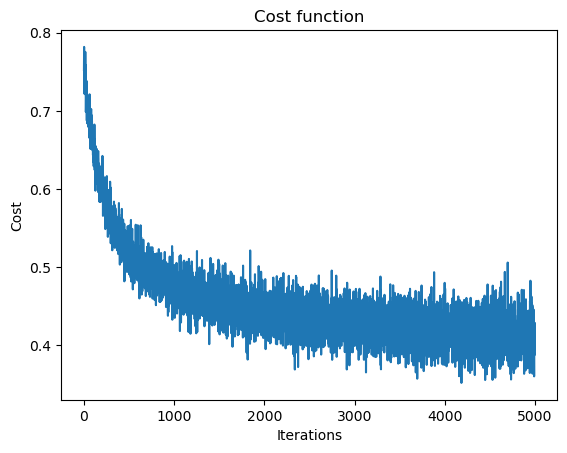

In [133]:
costs = model_with_dropout.train_model(train_X, train_Y, 5000)

### 3.1.2 Dropout Model Evaluation

In [134]:
train_acc = model_with_dropout.evaluate(train_X, train_Y)
dev_acc = model_with_dropout.evaluate(dev_X, dev_Y)
test_acc = model_with_dropout.evaluate(test_X, test_Y)

print(f'Train accuracy: {train_acc}')
print(f'Dev accuracy: {dev_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 0.931098696461825
Dev accuracy: 0.7652173913043478
Test accuracy: 0.8017241379310345


### 3.2.1. Model with L2 Regularization

### 3.2.2. L2 Regularization lambda tuning

In [135]:
def create_regularization_model(neurons):
  layers = []
  for neuron_index in range(1, len(neurons)):
    if neuron_index % 2 == 1:
      layer = BatchNormalizationLayer(neurons[neuron_index - 1], neurons[neuron_index], reluFunction, learning_rate)
    else:
      layer = DenseLayer(neurons[neuron_index - 1], neurons[neuron_index], reluFunction, learning_rate)
    layers.append(layer)

  layer = DenseLayer(neurons[-1], 1, sigmoidFunction, learning_rate)
  layers.append(layer)
  return Model(layers, classifier)

In [ ]:
# model hyperparameters
keep_prob =  1 # no dropout
a = -2
b =  1
lambda_count = 20
random_power = np.random.rand(lambda_count) * np.abs(a - b) + np.min([a, b])
l2_lambdas = np.power(10, random_power)
l2_lambdas = np.sort(l2_lambdas)
best_lambda = None
best_sol = 0
for l2_lambda in l2_lambdas:
  model_with_l2_regularization = create_regularization_model(neurons)
  costs = model_with_l2_regularization.train_model(train_X, train_Y, 1000, l2_lambda=l2_lambda, print_cost=False, plot_costs=False)
  train_acc = model_with_l2_regularization.evaluate(train_X, train_Y)
  dev_acc = model_with_l2_regularization.evaluate(dev_X, dev_Y)
  if dev_acc +  train_acc * 0.1 > best_sol:
    best_sol = dev_acc +  train_acc * 0.1
    best_lambda = l2_lambda
  # print(f'Model benchmarks for lambda = {l2_lambda}')
  # print(f'Train accuracy: {train_acc}')
  # print(f'Dev accuracy: {dev_acc}\n\n')

print(f'Best lambda: {best_lambda}')  
  

Best lambda: 0.05801032189138468


In [137]:
# model hyperparameters
l2_lambda = best_lambda # L2 regularization

model_with_l2_regularization = create_regularization_model(neurons)
print(model_with_l2_regularization)

[ BatchNormalizationLayer(30), 
 DenseLayer(30), 
 BatchNormalizationLayer(20), 
 DenseLayer(20), 
 BatchNormalizationLayer(15), 
 DenseLayer(20), 
 BatchNormalizationLayer(10), 
 DenseLayer(10), 
 BatchNormalizationLayer(8), 
 DenseLayer(1) ]


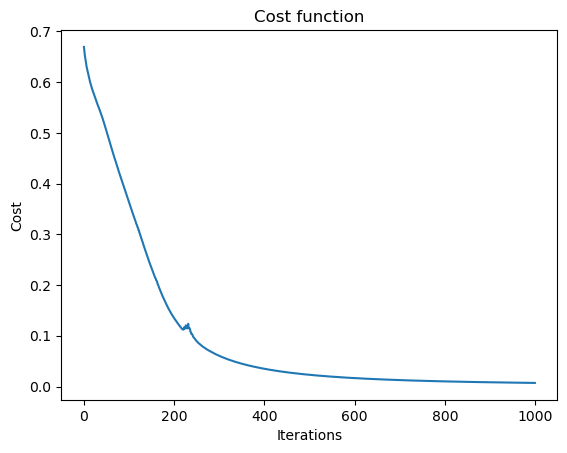

In [138]:
costs = model_with_l2_regularization.train_model(train_X, train_Y, 1000, l2_lambda=l2_lambda)

### 3.2.3. L2 Regularization Model Evaluation

In [139]:
train_acc = model_with_l2_regularization.evaluate(train_X, train_Y)
dev_acc = model_with_l2_regularization.evaluate(dev_X, dev_Y)
test_acc = model_with_l2_regularization.evaluate(test_X, test_Y)

print(f'Train accuracy: {train_acc}')
print(f'Dev accuracy: {dev_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 1.0
Dev accuracy: 0.6782608695652174
Test accuracy: 0.6810344827586207


### 3.2.4 Conclusion
The dropout is a better regularization technique for this dataset. The L2 regularization is not able to improve the model performance.

## 4. Tensorflow Model Blocks